In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts

### Load in all of the .csv files containing the measurements of morphological domains

In [9]:
csv_file_path = '/Volumes/Tatum_SSD-1/Grad_School/m2py/Morphology_labels/OPV_morph_maps/3_component/'
all_files = os.listdir(csv_file_path)
# print (all_files)
files = [fl for fl in all_files if fl[-1] == 'v']
print (len(files))
print (files)

36
['100C_15min_Sub4_Dev2_domain_metrics.csv', '100C_15min_Sub4_Dev4_domain_metrics.csv', '100C_15min_Sub4_Dev7_domain_metrics.csv', '100C_30min_Sub7_Dev2_domain_metrics.csv', '100C_30min_Sub7_Dev4_domain_metrics.csv', '100C_30min_Sub7_Dev7_domain_metrics.csv', '100C_5min_Sub1_Dev3_domain_metrics.csv', '100C_5min_Sub1_Dev4_90D_domain_metrics.csv', '100C_5min_Sub1_Dev4_domain_metrics.csv', '125C_15min_Sub4_Dev1_domain_metrics.csv', '125C_15min_Sub4_Dev2_domain_metrics.csv', '125C_15min_Sub4_Dev6_domain_metrics.csv', '125C_15min_Sub4_Dev7_domain_metrics.csv', '125C_15min_Sub4_postexam_domain_metrics.csv', '125C_30min_Sub8_Dev3_domain_metrics.csv', '125C_30min_Sub8_postexam_domain_metrics.csv', '125C_5min_Sub1_Dev2_domain_metrics.csv', '125C_5min_Sub1_Dev3_domain_metrics.csv', '125C_5min_Sub1_Dev6_domain_metrics.csv', '125C_5min_Sub1_postexam_domain_metrics.csv', '150C_15min_Sub4_Dev1_domain_metrics.csv', '150C_15min_Sub4_Dev7_domain_metrics.csv', '150C_30min_Sub7_Dev3_domain_metrics.csv'

In [10]:
df = pd.read_csv(csv_file_path+files[0])
df.head()

,Unnamed: 0,label,area,filled_area,extent,major_axis_length,minor_axis_length,eccentricity,orientation,perimeter
0,2,1.0,4325.0,5413.0,0.258487,165.767738,92.859394,0.828372,0.070320,2412.428678
1,3,1.0,4238.0,5062.0,0.235877,168.717121,98.080941,0.813665,-1.400632,2299.215475
2,4,2.0,3197.0,3393.0,0.320887,136.126776,61.656975,0.891542,-0.166490,1346.218434
3,5,1.0,2173.0,2268.0,0.238791,91.907145,76.373368,0.556296,0.581471,1231.886435
4,6,2.0,1922.0,1980.0,0.145661,160.382852,39.439103,0.969294,-1.236355,911.423448


### For each time-temperature point:


- Sort domains by their phase
- Calculate average and standard deviation of domain descriptors
- Append those values to a phase-specific DataFrame

## Need to make sure domain also has time, temp, substrate, and device tags!!

In [11]:
# Define dataframes to hold statistics for each phase
final_df = pd.DataFrame(columns = ['Anneal_time', 'Anneal_temp', 'Substrate', 'Device',
                                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',
                                   
                                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',
                                   
                                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev'])


#For each file, sort by GMM label, compute avg and stdev of each column, append values to phase summary dataframes
for fl in files:
    df = pd.read_csv(csv_file_path+fl)
    df.rename(columns = {'Unnamed: 0': 'Domain_label', 'label': 'GMM_label'}, inplace = True)
    
    # Obtain anneal time and temperature from filename
    if 'NOANNEAL' in fl:
        anl_time = 0
        anl_temp = 0
        
    else:
        temp_stop_indx = fl.index('C')
        anl_temp = int(fl[:temp_stop_indx])


        time_start_indx = temp_stop_indx+2
        time_stop_indx = fl.index('m')
        time_stop_indx = time_stop_indx
        anl_time = fl[time_start_indx:time_stop_indx]
        anl_time = int(anl_time)
        
    # Obtain substrate and device numnbers from filename
    sub = 0
    dev = 0
    
    if fl.find('Sub') != -1:
        sub_indeces = fl.index('Sub')
        sub_index = sub_indeces+3
        sub = fl[sub_index]
        
        if fl.find('postexam') != -1:
            dev = 3

        else:
            dev_indeces = fl.index('Dev')
            dev_index = dev_indeces+3
            dev = fl[dev_index]
    
    elif fl.find('Sub') == -1:
        sub_indeces = fl.index('S')
        sub_index = sub_indeces+1
        sub = fl[sub_index]

        dev_indeces = fl.index('D')
        dev_index = dev_indeces+1
        dev = fl[dev_index]
        
    else:
        print ('woops...substrate and device location went screwy')
    
    rel_areas = nuts.relative_areas(df)

    temp_p1 = df[df['GMM_label'] == 1]
    temp_p2 = df[df['GMM_label'] == 2]
    temp_p3 = df[df['GMM_label'] == 3]

    avg1 = temp_p1['area'].mean()
    std1 = temp_p1['area'].std()
    
    avg2 = temp_p1['filled_area'].mean()
    std2 = temp_p1['filled_area'].std()
    
    avg3 = temp_p1['extent'].mean()
    std3 = temp_p1['extent'].std()
    
    avg4 = temp_p1['major_axis_length'].mean()
    std4 = temp_p1['major_axis_length'].std()

    avg5 = temp_p1['minor_axis_length'].mean()
    std5 = temp_p1['minor_axis_length'].std()
    
    avg6 = temp_p1['eccentricity'].mean()
    std6 = temp_p1['eccentricity'].std()

    avg7 = temp_p1['orientation'].mean()
    std7 = temp_p1['orientation'].std()

    avg8 = temp_p1['perimeter'].mean()
    std8 = temp_p1['perimeter'].std()
    
    avg9 = temp_p2['area'].mean()
    std9 = temp_p2['area'].std()
    
    avg10 = temp_p2['filled_area'].mean()
    std10 = temp_p2['filled_area'].std()
    
    avg11 = temp_p2['extent'].mean()
    std11 = temp_p2['extent'].std()
    
    avg12 = temp_p2['major_axis_length'].mean()
    std12 = temp_p2['major_axis_length'].std()

    avg13 = temp_p2['minor_axis_length'].mean()
    std13 = temp_p2['minor_axis_length'].std()

    avg14 = temp_p2['eccentricity'].mean()
    std14 = temp_p2['eccentricity'].std()

    avg15 = temp_p2['orientation'].mean()
    std15 = temp_p2['orientation'].std()

    avg16 = temp_p2['perimeter'].mean()
    std16 = temp_p2['perimeter'].std()
    
    avg17 = temp_p3['area'].mean()
    std17 = temp_p3['area'].std()
    
    avg18 = temp_p3['filled_area'].mean()
    std18 = temp_p3['filled_area'].std()
    
    avg19 = temp_p3['extent'].mean()
    std19 = temp_p3['extent'].std()
    
    avg20 = temp_p3['major_axis_length'].mean()
    std20 = temp_p3['major_axis_length'].std()

    avg21 = temp_p3['minor_axis_length'].mean()
    std21 = temp_p3['minor_axis_length'].std()

    avg22 = temp_p3['eccentricity'].mean()
    std22 = temp_p3['eccentricity'].std()

    avg23 = temp_p3['orientation'].mean()
    std23 = temp_p3['orientation'].std()

    avg24 = temp_p3['perimeter'].mean()
    std24 = temp_p3['perimeter'].std()

    final_df = final_df.append(pd.Series({'Anneal_time':anl_time, 'Anneal_temp':anl_temp,
                                          'Substrate':sub, 'Device':dev,
                                          'p1_fraction':rel_areas[0],
                                          'p2_fraction':rel_areas[1],
                                          'p3_fraction':rel_areas[2], 'p1_area_avg':avg1,
                                          'p1_area_stdev':std1, 'p1_filled_area_avg':avg2,
                                          'p1_filled_area_stdev':std2, 'p1_extent_avg':avg3,
                                          'p1_extent_stdev':std3, 'p1_MajorAL_avg':avg4,
                                          'p1_MajorAL_stdev':std4, 'p1_MinorAL_avg':avg5,
                                          'p1_MinorAL_stdev':std5, 'p1_Ecc_avg':avg6,
                                          'p1_Ecc_stdev':std6,'p1_Orient_avg':avg7,
                                          'p1_Orient_stdev':std7, 'p1_Perim_avg':avg8,
                                          'p1_Perim_stdev':std8, 'p2_area_avg':avg9,
                                          'p2_area_stdev':std9, 'p2_filled_area_avg':avg10,
                                          'p2_filled_area_stdev':std10, 'p2_extent_avg':avg11,
                                          'p2_extent_stdev':std11, 'p2_MajorAL_avg':avg12,
                                          'p2_MajorAL_stdev':std12, 'p2_MinorAL_avg':avg13,
                                          'p2_MinorAL_stdev':std13, 'p2_Ecc_avg':avg14,
                                          'p2_Ecc_stdev':std14, 'p2_Orient_avg':avg15,
                                          'p2_Orient_stdev':std15, 'p2_Perim_avg':avg16,
                                          'p2_Perim_stdev':std16, 'p3_area_avg':avg17,
                                          'p3_area_stdev':std17, 'p3_filled_area_avg':avg18,
                                          'p3_filled_area_stdev':std18, 'p3_extent_avg':avg19,
                                          'p3_extent_stdev':std19, 'p3_MajorAL_avg':avg20,
                                          'p3_MajorAL_stdev':std20, 'p3_MinorAL_avg':avg21,
                                          'p3_MinorAL_stdev':std21, 'p3_Ecc_avg':avg22,
                                          'p3_Ecc_stdev':std22, 'p3_Orient_avg':avg23,
                                          'p3_Orient_stdev':std23, 'p3_Perim_avg':avg24,
                                          'p3_Perim_stdev':std24}), ignore_index = True)
    
    print('x')


x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x


## Need to add all areas together and calculate normalized phase ratios for each sample

In [12]:
final_df.head()

,Anneal_time,Anneal_temp,Substrate,Device,p1_fraction,p2_fraction,p3_fraction,p1_area_avg,p1_area_stdev,p1_filled_area_avg,...,p3_MajorAL_avg,p3_MajorAL_stdev,p3_MinorAL_avg,p3_MinorAL_stdev,p3_Ecc_avg,p3_Ecc_stdev,p3_Orient_avg,p3_Orient_stdev,p3_Perim_avg,p3_Perim_stdev
0,15,100,4,2,0.377864,0.397964,0.224172,138.756250,515.165733,152.975000,...,10.438380,8.106913,5.463893,4.242163,0.806425,0.141707,-0.028958,1.145651,27.843437,33.295642
1,15,100,4,4,0.350601,0.368873,0.280526,78.978947,180.249005,81.140351,...,13.322208,13.820978,6.518197,6.261752,0.817408,0.147199,0.053783,1.171795,42.334954,73.576430
2,15,100,4,7,0.290203,0.329655,0.380142,122.638743,246.651556,125.879581,...,13.538155,13.008734,6.490835,7.113326,0.840800,0.129785,-0.158463,1.160457,42.913004,88.566792
3,30,100,7,2,0.255200,0.437277,0.307523,151.263158,607.110300,172.934211,...,13.088719,13.436382,5.615066,4.358445,0.836830,0.122449,-0.486800,0.858037,34.541492,46.688722
4,30,100,7,4,0.363801,0.396645,0.239554,151.330935,441.730661,158.848921,...,11.863984,9.149436,5.579089,3.184688,0.817914,0.131814,-0.111498,1.075222,29.762502,28.652323


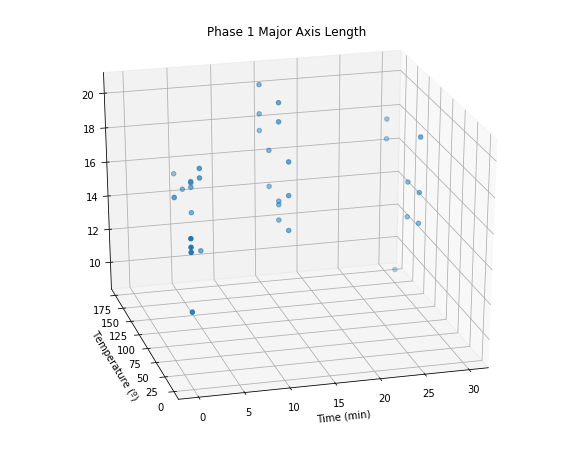

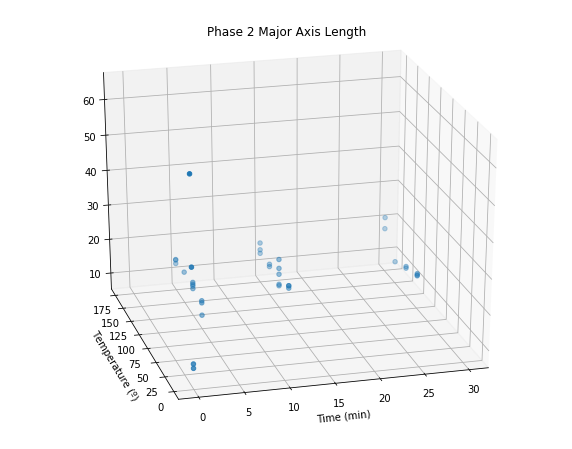

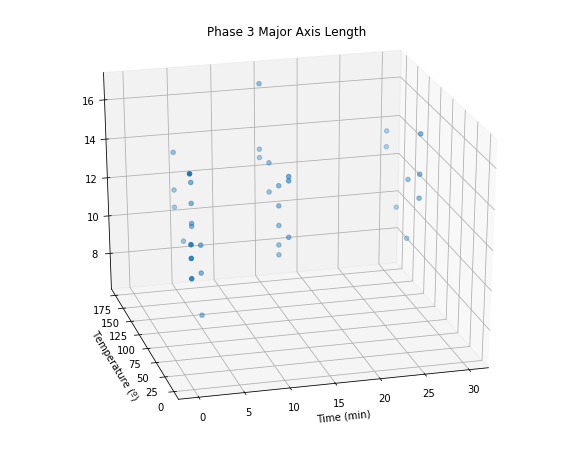

In [13]:
x1 = final_df['Anneal_time']
y1 = final_df['Anneal_temp']
z1 = final_df['p1_MajorAL_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 1 Major Axis Length')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x2 = final_df['Anneal_time']
y2 = final_df['Anneal_temp']
z2 = final_df['p2_MajorAL_avg']
fig2 = plt.figure(figsize = (10,8))
ax2 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 2 Major Axis Length')
ax2.scatter3D(x2,y2,z2)
ax2.view_init(25, 255)
plt.show()

x3 = final_df['Anneal_time']
y3 = final_df['Anneal_temp']
z3 = final_df['p3_MajorAL_avg']
fig3 = plt.figure(figsize = (10,8))
ax3 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 3 Major Axis Length')
ax3.scatter3D(x3,y3,z3)
ax3.view_init(25, 255)
plt.show()

# Now we need to read in the device data and associate it with its morphology descriptors

# This cell was for initially converting everything to pandas. A new, formatted & filtered spreadsheet now exists

In [10]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OPV_device.xlsx')
device_df = device_df.fillna(method = 'ffill') # B/c of excel formatting, NaN values arise from merged cells. Use previous value to fill NaN's
device_df

device_df['Substrate'] = 0

for i in range(len(device_df['File Name'])):
    fl = device_df['File Name'][i]
    sub_indeces = 0
    sub_index = 0
    sub = 0
    
    print (fl)
    
    if fl.find('Sub') != -1:
        sub_indeces = fl.index('Sub')
        sub_index = sub_indeces+3
        sub = fl[sub_index]
#         print (sub)
        
    elif fl.find('SUB') != -1:
        sub_indeces = fl.index('SUB')
        sub_index = sub_indeces+3
        sub = fl[sub_index]
#         print (sub)

    elif fl.find('NA') != -1:
        device_df['Time (min)'] = 0
        devie_df['Temp (C)'] = 0
        
    else:
        print ('woops...substrate and device location went screwy')
        
    device_df['Substrate'][i] = int(sub)

KeyError: 'File Name'

# This cell utilizes the formatted & filtered spreadsheet

In [14]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OPV_device_df.xlsx')
device_df.head()

,Unnamed: 0,Unnamed: 0.1,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
0,0,291,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,5,0,0.053196,0.088773,2.319470,25.835041,1
1,1,283,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,5,0,0.323514,0.706579,2.021489,22.649638,7
2,2,284,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,6,0,0.620043,0.665916,1.867738,49.852415,7
3,3,280,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,2,0,0.628255,0.654254,1.915640,50.127434,7
4,4,287,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,1,0,0.637683,0.662407,2.204954,43.659713,1


In [15]:
# device_df.to_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')

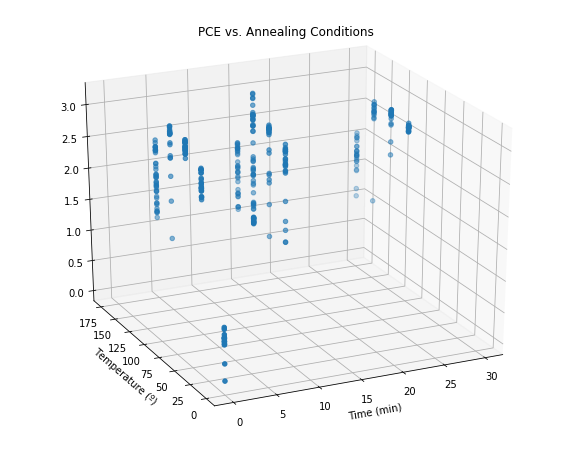

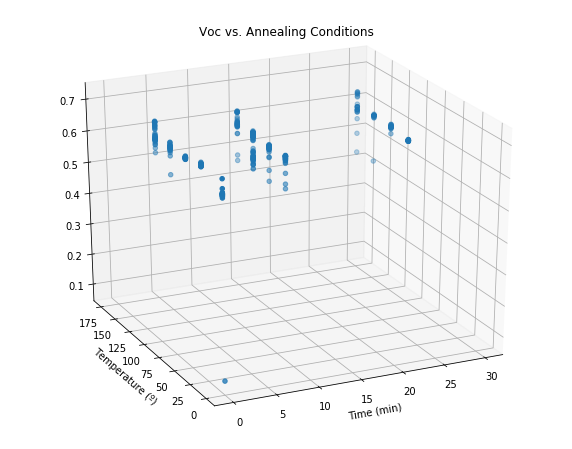

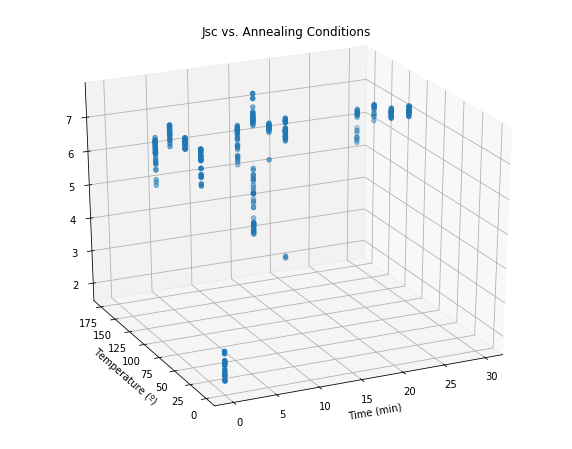

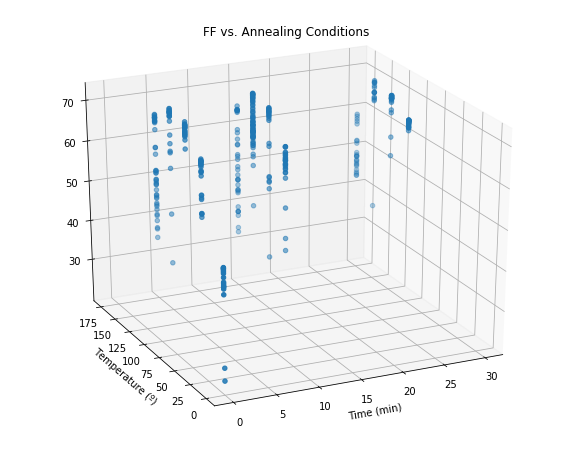

In [16]:
x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['PCE']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('PCE vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['VocL']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Voc vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['Jsc']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Jsc vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['FF']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('FF vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

In [16]:
# device_df.to_excel('~/Desktop/OPV_device_df.xlsx')

# Now that the data is read in plottable, we need to use all of these parameters to predict device performance


- Create a new df with only columns needed for models
- Make sure device data is properly matched with morphology data (via time, temp, substrate, device)
- Want to fit a function that predicts PCE, Jsc, Voc, and FF from morphology and processing conditions

$$
PCE, Jsc, Voc, FF = f(anneal time, anneal temp, major axis, minor axis, perimenter, orientation, eccentricity)
$$

The problem is that there are way more devices tested than AFM images taken and processed. So, for now, the dataframe will only contain device data for those devices with morphology data too. In the full model (_i.e._ the neural network model), I'll have to find a way to use all data in training.

In [17]:
# total_df = Phase1 + Phase2 + Phase3 + device_df

Phase1['GMM_label'] = 1
Phase2['GMM_label'] = 2
Phase3['GMM_label'] = 3

total_df = Phase1.copy()
print (total_df.shape)
print (total_df.head())

total_df = total_df.append(Phase2)
print (total_df.shape)
print (total_df.head())

total_df = total_df.append(Phase3)
print (total_df.shape)
print (total_df.head())

total_df['PCE'] = 0
total_df['VocL'] = 0
total_df['Jsc'] = 0
total_df['FF'] = 0

total_df.head()

NameError: name 'Phase1' is not defined

In [17]:
# for each row in total_df, find row in device_df with same time, temp, sub, and dev. then append PCE, Jsc, Voc, and FF values to total_df

final_df['PCE'] = 0
final_df['VocL'] = 0
final_df['Jsc'] = 0
final_df['FF'] = 0

NA_count = 0 # NA = no anneal, whose filenames have different schemes

for i in range(len(final_df['Anneal_time'])):
    print (i)
    pce = 0
    voc = 0
    jsc = 0
    ff = 0
    
    time = final_df['Anneal_time'].iloc[i]
    temp = final_df['Anneal_temp'].iloc[i]
    sub = final_df['Substrate'].iloc[i]
    sub = int(sub)
    dev = final_df['Device'].iloc[i]
    dev = int(dev)
    
    time_df = device_df[device_df['Time (min)'] == time]
    temp_df = time_df[time_df['Temp (C)'] == temp]
    sub_df = temp_df[temp_df['Substrate'] == sub]
    dev_row = sub_df[sub_df['Device'] == dev]
    
    
    if dev_row.shape[0] != 0:
    
        pce = dev_row['PCE'].iloc[-1]
        voc = dev_row['VocL'].iloc[-1]
        jsc = dev_row['Jsc'].iloc[-1]
        ff = dev_row['FF'].iloc[-1]
        
    elif dev_row.shape[0] == 0:
        if time == 0:
            
            NA_df = device_df[device_df['Time (min)'] == time]
            
            pce = NA_df['PCE'].iloc[NA_count]
            voc = NA_df['VocL'].iloc[NA_count]
            jsc = NA_df['Jsc'].iloc[NA_count]
            ff = NA_df['FF'].iloc[NA_count]
            
            NA_count += 1 
            
        else:
            pass
    else:
        pass
        
    final_df['PCE'].iloc[i] = pce
    final_df['VocL'].iloc[i] = voc
    final_df['Jsc'].iloc[i] = jsc
    final_df['FF'].iloc[i] = ff
    
final_df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Anneal_time,Anneal_temp,Substrate,Device,p1_fraction,p2_fraction,p3_fraction,p1_area_avg,p1_area_stdev,p1_filled_area_avg,...,p3_Ecc_avg,p3_Ecc_stdev,p3_Orient_avg,p3_Orient_stdev,p3_Perim_avg,p3_Perim_stdev,PCE,VocL,Jsc,FF
0,15,100,4,2,0.377864,0.397964,0.224172,138.756250,515.165733,152.975000,...,0.806425,0.141707,-0.028958,1.145651,27.843437,33.295642,2.311387,0.577792,6.963861,57.44484
1,15,100,4,4,0.350601,0.368873,0.280526,78.978947,180.249005,81.140351,...,0.817408,0.147199,0.053783,1.171795,42.334954,73.576430,1.763230,0.522596,7.047848,47.87256
2,15,100,4,7,0.290203,0.329655,0.380142,122.638743,246.651556,125.879581,...,0.840800,0.129785,-0.158463,1.160457,42.913004,88.566792,2.394418,0.575790,6.939877,59.92170
3,30,100,7,2,0.255200,0.437277,0.307523,151.263158,607.110300,172.934211,...,0.836830,0.122449,-0.486800,0.858037,34.541492,46.688722,2.628197,0.569525,7.301575,63.20169
4,30,100,7,4,0.363801,0.396645,0.239554,151.330935,441.730661,158.848921,...,0.817914,0.131814,-0.111498,1.075222,29.762502,28.652323,2.710602,0.568631,7.328048,65.04993


In [18]:
final_df.to_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OPV_total_df.xlsx')

# We have all our device and morphology data in total_df. Now we can use it to train regression models for in-depth plotting!!

In [23]:
X = final_df[['Anneal_time', 'Anneal_temp', 'Substrate', 'Device',
              'p1_fraction', 'p2_fraction', 'p3_fraction',
              'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
              'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
              'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
              'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
              'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

              'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
              'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
              'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
              'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
              'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

              'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
              'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
              'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
              'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
              'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']] # all of the different features, including annealing conditions
Y = final_df[['PCE', 'VocL', 'Jsc', 'FF']] # device performance

x_train, x_test, y_train, y_test = train_test_split(X, Y)

alphas = np.logspace(-6, 1, 200)
coeffs = {}
train_errors = []
test_errors = []

for i, a in enumerate(alphas):
    lasso = linear_model.Lasso(alpha = a)
    lasso.fit(x_train, y_train)

    y_train_pred = lasso.predict(x_train)
    y_test_pred = lasso.predict(x_test)


    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    coeffs[i]=lasso.coef_
    train_errors.append(train_mse)
    test_errors.append(test_mse)

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043864465670541645, tolerance: 0.0033854187850296913
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004149892809305647, tolerance: 0.003406208799234839
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00614792478853036, tolerance: 0.004301615505489287
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

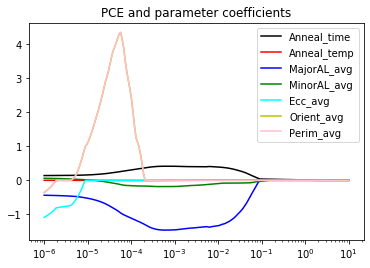

In [30]:
pce_co1 = []
pce_co2 = []
pce_co3 = []
pce_co4 = []
pce_co5 = []
pce_co6 = []
pce_co7 = []

for k in coeffs.keys():
    pce_co1.append(coeffs[k][0][0])
    pce_co2.append(coeffs[k][0][1])
    pce_co3.append(coeffs[k][0][2])
    pce_co4.append(coeffs[k][0][3])
    pce_co5.append(coeffs[k][0][4])
    pce_co6.append(coeffs[k][0][5])
    pce_co7.append(coeffs[k][0][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, pce_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, pce_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, pce_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, pce_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, pce_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, pce_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, pce_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('PCE and parameter coefficients')
plt.show()

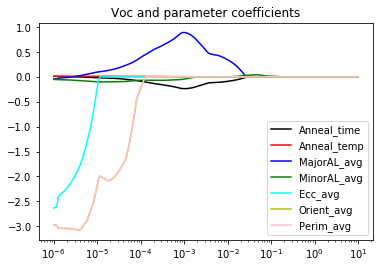

In [31]:
voc_co1 = []
voc_co2 = []
voc_co3 = []
voc_co4 = []
voc_co5 = []
voc_co6 = []
voc_co7 = []

for k in coeffs.keys():
    voc_co1.append(coeffs[k][1][0])
    voc_co2.append(coeffs[k][1][1])
    voc_co3.append(coeffs[k][1][2])
    voc_co4.append(coeffs[k][1][3])
    voc_co5.append(coeffs[k][1][4])
    voc_co6.append(coeffs[k][1][5])
    voc_co7.append(coeffs[k][1][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, voc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, voc_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, voc_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, voc_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, voc_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, voc_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, voc_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Voc and parameter coefficients')
plt.show()

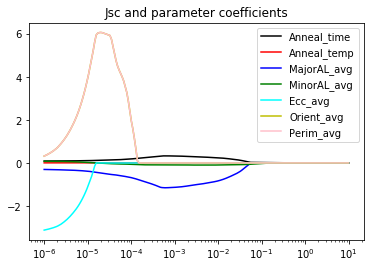

In [32]:
jsc_co1 = []
jsc_co2 = []
jsc_co3 = []
jsc_co4 = []
jsc_co5 = []
jsc_co6 = []
jsc_co7 = []

for k in coeffs.keys():
    jsc_co1.append(coeffs[k][2][0])
    jsc_co2.append(coeffs[k][2][1])
    jsc_co3.append(coeffs[k][2][2])
    jsc_co4.append(coeffs[k][2][3])
    jsc_co5.append(coeffs[k][2][4])
    jsc_co6.append(coeffs[k][2][5])
    jsc_co7.append(coeffs[k][2][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, jsc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, jsc_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, jsc_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, jsc_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, jsc_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, jsc_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, jsc_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Jsc and parameter coefficients')
plt.show()

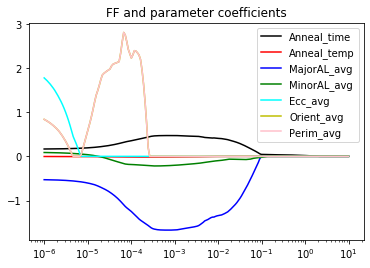

In [33]:
ff_co1 = []
ff_co2 = []
ff_co3 = []
ff_co4 = []
ff_co5 = []
ff_co6 = []
ff_co7 = []

for k in coeffs.keys():
    ff_co1.append(coeffs[k][3][0])
    ff_co2.append(coeffs[k][3][1])
    ff_co3.append(coeffs[k][3][2])
    ff_co4.append(coeffs[k][3][3])
    ff_co5.append(coeffs[k][3][4])
    ff_co6.append(coeffs[k][3][5])
    ff_co7.append(coeffs[k][3][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, ff_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, ff_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, ff_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, ff_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, ff_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, ff_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, ff_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('FF and parameter coefficients')
plt.show()

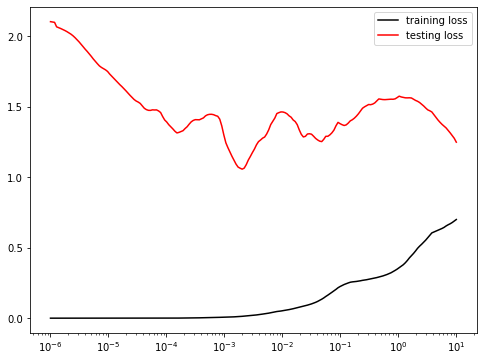

In [34]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(alphas, train_errors, c = 'k', label = 'training loss')
plt.plot(alphas, test_errors, c = 'r', label = 'testing loss')
ax.set_xscale('log')
plt.legend()
plt.show()

# Generate a LASSO fit with the best alpha, determined from graph above. Then use it to predict each target feature and visualize

In [35]:
lasso = linear_model.Lasso(alpha = 0.00001)
lasso.fit(x_train, y_train)

y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03249762273016885, tolerance: 0.0033854187850296913
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01921910479424796, tolerance: 0.013280148938470364
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027380233293525496, tolerance: 0.003406208799234839
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: O

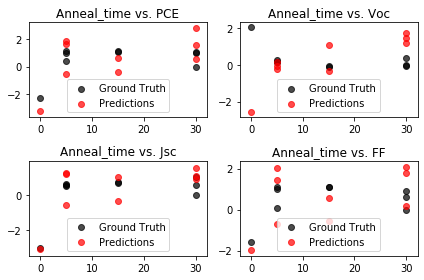

In [36]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Anneal_time'], y_test['PCE'], c = 'k', label = 'Ground Truth', alpha = 0.7)
plt.scatter(x_test['Anneal_time'], y_test_pred[:,0], c = 'r', label = 'Predictions', alpha = 0.7)
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. PCE')

plt.subplot(222)
plt.scatter(x_test['Anneal_time'], y_test['VocL'], c = 'k', label = 'Ground Truth', alpha = 0.7)
plt.scatter(x_test['Anneal_time'], y_test_pred[:,1], c = 'r', label = 'Predictions', alpha = 0.7)
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. Voc')

plt.subplot(223)
plt.scatter(x_test['Anneal_time'], y_test['Jsc'], c = 'k', label = 'Ground Truth', alpha = 0.7)
plt.scatter(x_test['Anneal_time'], y_test_pred[:,2], c = 'r', label = 'Predictions', alpha = 0.7)
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. Jsc')

plt.subplot(224)
plt.scatter(x_test['Anneal_time'], y_test['FF'], c = 'k', label = 'Ground Truth', alpha = 0.7)
plt.scatter(x_test['Anneal_time'], y_test_pred[:,3], c = 'r', label = 'Predictions', alpha = 0.7)
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. FF')

plt.tight_layout()
plt.show()

In [42]:
print(y_test_pred)

[[-0.4037617   1.11363901 -0.34755681 -0.57588752]
 [ 2.76797201  1.73602341  1.55835107  2.06500575]
 [-0.54530474  0.14566893 -0.57717889 -0.71435066]
 [ 1.60449838 -0.22741974  1.19724084  1.44104014]
 [ 1.53669579  1.17302157  0.9292251   1.80613597]
 [ 0.60828312 -0.3414595   1.00486131  0.57835691]
 [-3.22488987 -2.53952704 -3.11246891 -1.94772828]
 [ 1.83670115 -0.07066417  1.22848006  2.04473646]
 [ 0.57152378  1.48733137  1.08091676  0.15633562]]


______________________________________________
______________________________________________

# Troubleshooting and developing below here

______________________________________________
______________________________________________

In [30]:
for fl in files:
    print (fl)
    if fl.find('Sub') != -1:
        sub_indeces = fl.index('Sub')
        sub_index = sub_indeces+3
        sub = fl[sub_index]
        print (sub)
        
        if fl.find('postexam') != -1:
            dev = 3
            print (dev)

        else:
            dev_indeces = fl.index('Dev')
            dev_index = dev_indeces+3
            dev = fl[dev_index]
            print (dev)
    
    elif fl.find('Sub') == -1:
        sub_indeces = fl.index('S')
        sub_index = sub_indeces+1
        sub = fl[sub_index]
        print (sub)

        dev_indeces = fl.index('D')
        dev_index = dev_indeces+1
        dev = fl[dev_index]
        print (dev)
        
    else:
        print ('woops')

100C_15min_Sub4_Dev2_domain_metrics.csv
4
2
100C_15min_Sub4_Dev4_domain_metrics.csv
4
4
100C_15min_Sub4_Dev7_domain_metrics.csv
4
7
100C_30min_Sub7_Dev2_domain_metrics.csv
7
2
100C_30min_Sub7_Dev4_domain_metrics.csv
7
4
100C_30min_Sub7_Dev7_domain_metrics.csv
7
7
100C_5min_Sub1_Dev3_domain_metrics.csv
1
3
100C_5min_Sub1_Dev4_90D_domain_metrics.csv
1
4
100C_5min_Sub1_Dev4_domain_metrics.csv
1
4
125C_15min_Sub4_Dev1_domain_metrics.csv
4
1
125C_15min_Sub4_Dev2_domain_metrics.csv
4
2
125C_15min_Sub4_Dev6_domain_metrics.csv
4
6
125C_15min_Sub4_Dev7_domain_metrics.csv
4
7
125C_15min_Sub4_postexam_domain_metrics.csv
4
3
125C_30min_Sub8_Dev3_domain_metrics.csv
8
3
125C_30min_Sub8_postexam_domain_metrics.csv
8
3
125C_5min_Sub1_Dev2_domain_metrics.csv
1
2
125C_5min_Sub1_Dev3_domain_metrics.csv
1
3
125C_5min_Sub1_Dev6_domain_metrics.csv
1
6
125C_5min_Sub1_postexam_domain_metrics.csv
1
3
150C_15min_Sub4_Dev1_domain_metrics.csv
4
1
150C_15min_Sub4_Dev7_domain_metrics.csv
4
7
150C_30min_Sub7_Dev3_do

In [43]:
100 == 100.0

True

In [16]:
time = 0
temp = 0
sub = 4
dev = 2


test = device_df[device_df['Time (min)'] == time]
print (test.shape)

test1 = test[test['Temp (C)'] == temp]
print (test1.shape)

test2 = test1[test1['Substrate'] == sub]
print (test2.shape)

test3 = test2[test2['Device'] == dev]
print (test3.shape)
test3

(16, 9)
(16, 9)
(0, 9)
(0, 9)


,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate


In [17]:
test1

,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
544,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,1,0,0.677627,0.677331,2.144910,46.642351,7
545,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,2,0,0.628255,0.654254,1.915640,50.127434,7
546,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,3,0,0.667399,0.659943,2.022991,49.990281,7
547,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,4,0,0.725201,0.655834,2.428190,45.538834,7
548,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,5,0,0.323514,0.706579,2.021489,22.649638,7
549,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,6,0,0.620043,0.665916,1.867738,49.852415,7
550,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,7,0,0.670255,0.659979,2.084238,48.726225,7
551,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,8,0,0.721146,0.649909,2.436711,45.537223,7
552,2019_4_16_P3HTPCBM_NA_3000_SUB1,0.0,1,0,0.637683,0.662407,2.204954,43.659713,1
553,2019_4_16_P3HTPCBM_NA_3000_SUB1,0.0,2,0,0.706948,0.662689,2.368623,45.038290,1


In [19]:
time = 0
temp = 0
sub = 4
dev = 2


test = total_df[total_df['Anneal_time'] == time]
print (test.shape)

test1 = test[test['Anneal_temp'] == temp]
print (test1.shape)

test2 = test1[test1['Substrate'] == sub]
print (test2.shape)

test3 = test2[test2['Device'] == dev]
print (test3.shape)

test

(12, 19)
(12, 19)
(0, 19)
(0, 19)


,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
32,0,0,1,1,16.958970,22.979118,6.928658,10.234174,0.886164,0.128352,0.297267,1.299622,80.994690,248.046190,1,0.637683,0.662407,2.204954,43.659713
33,0,0,1,4,12.789539,11.140250,4.982281,3.771026,0.870516,0.119248,-0.022813,0.450956,32.447792,40.095020,1,0.861752,0.657279,2.667796,49.145099
34,0,0,2,1,17.263545,20.648460,5.901084,8.564153,0.910885,0.114003,0.320258,1.350832,65.587095,168.705097,1,0.000000,0.000000,0.000000,0.000000
35,0,0,3,1,16.998574,18.822216,6.773289,10.292247,0.905655,0.131148,0.311354,1.327269,80.421039,193.972284,1,0.000000,0.000000,0.000000,0.000000
32,0,0,1,1,11.202835,7.284830,3.572354,3.047932,0.915905,0.099707,0.303322,1.350191,21.195398,24.027392,2,0.000000,0.000000,0.000000,0.000000
33,0,0,1,4,12.547662,11.525117,4.739958,3.338181,0.869578,0.114944,-0.040305,0.481310,31.213935,41.415615,2,0.000000,0.000000,0.000000,0.000000
34,0,0,2,1,63.497943,46.676196,23.737751,15.533809,0.874847,0.098832,-0.096706,0.941245,191.254180,148.301406,2,0.000000,0.000000,0.000000,0.000000
35,0,0,3,1,38.920829,53.250404,14.457086,16.819504,0.875440,0.122771,0.253362,1.239796,142.401644,212.630909,2,0.000000,0.000000,0.000000,0.000000
32,0,0,1,1,16.654294,15.085095,8.133557,5.965564,0.788927,0.169774,0.278759,0.938508,51.860395,56.845220,3,0.000000,0.000000,0.000000,0.000000
33,0,0,1,4,11.625077,9.366525,4.454145,2.902850,0.875493,0.111169,-0.038648,0.434782,27.016969,29.474921,3,0.000000,0.000000,0.000000,0.000000
